# SpringBoard Capstone2: Coronavirus Tweets
## Unit7: Data Wrangling

    Data from Kaggle.com: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification/metadata

In [1]:
# !pip install wordcloud

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Ling/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud
import re
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
tweet_whole_train = pd.read_csv('/Users/Ling/Desktop/01_Springboard/Corona_Tweet/Data/Corona_NLP_train.csv', index_col = 0)
print(tweet_whole_train.info())
test = pd.read_csv('/Users/Ling/Desktop/01_Springboard/Corona_Tweet/Data/Corona_NLP_test.csv', index_col = 0)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 3799 to 44955
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ScreenName     41157 non-null  int64 
 1   Location       32567 non-null  object
 2   TweetAt        41157 non-null  object
 3   OriginalTweet  41157 non-null  object
 4   Sentiment      41157 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3798 entries, 1 to 3798
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ScreenName     3798 non-null   int64 
 1   Location       2964 non-null   object
 2   TweetAt        3798 non-null   object
 3   OriginalTweet  3798 non-null   object
 4   Sentiment      3798 non-null   object
dtypes: int64(1), object(4)
memory usage: 178.0+ KB
None


In [5]:
print(tweet_whole_train.head())

          ScreenName   Location     TweetAt  \
UserName                                      
3799           48751     London  16-03-2020   
3800           48752         UK  16-03-2020   
3801           48753  Vagabonds  16-03-2020   
3802           48754        NaN  16-03-2020   
3803           48755        NaN  16-03-2020   

                                              OriginalTweet  \
UserName                                                      
3799      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
3800      advice Talk to your neighbours family to excha...   
3801      Coronavirus Australia: Woolworths to give elde...   
3802      My food stock is not the only one which is emp...   
3803      Me, ready to go at supermarket during the #COV...   

                   Sentiment  
UserName                      
3799                 Neutral  
3800                Positive  
3801                Positive  
3802                Positive  
3803      Extremely Negative  


In [6]:
tweet = tweet_whole_train[['OriginalTweet', 'Sentiment']]

In [7]:
np.sum(tweet.isnull().any(axis=1))

0

In [8]:
np.unique(tweet.Sentiment, return_counts = True)

(array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
        'Positive'], dtype=object),
 array([ 5481,  6624,  9917,  7713, 11422]))

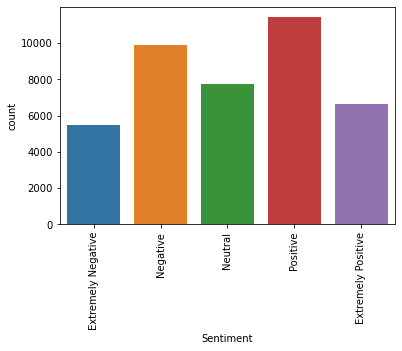

In [9]:
order = ['Extremely Negative', 'Negative', 'Neutral','Positive','Extremely Positive']
sns.countplot(x = 'Sentiment', data = tweet, order = order)
plt.xticks(rotation = 90)
plt.show()

#### reference: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

In [10]:
# lower case all text
tweet['OriginalTweet'] = tweet['OriginalTweet'].str.lower()
#tweet['OriginalTweet'] = tweet_text 
tweet['OriginalTweet'].head(10)

<ipython-input-10-a4d75c87a5e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].str.lower()


UserName
3799    @menyrbie @phil_gahan @chrisitv https://t.co/i...
3800    advice talk to your neighbours family to excha...
3801    coronavirus australia: woolworths to give elde...
3802    my food stock is not the only one which is emp...
3803    me, ready to go at supermarket during the #cov...
3804    as news of the regions first confirmed covid-...
3805    cashier at grocery store was sharing his insig...
3806    was at the supermarket today. didn't buy toile...
3807    due to covid-19 our retail store and classroom...
3808    for corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

In [11]:
stopwordlist = ['a','ain', 'am', 'an',
             'and','any','are', 'as', 'at', 'be',  'before',
             'being', 'between', 'by', 'can', 'd', 'do',
             'does', 'doing',  'during',  'for', 'from',
             'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'in',
             'into','is', 'it', 'its', 'itself', 'll', 'm', 'ma',
             'me', 'my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'or',  'our', 'ours','ourselves',  'own', 're','s', 'she', "shes", 
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 've', 
             'we',  'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: cleaning_stopwords(text))
tweet['OriginalTweet'].head()

<ipython-input-12-6c09ff49c4a4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: cleaning_stopwords(text))


UserName
3799    @menyrbie @phil_gahan @chrisitv https://t.co/i...
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia: woolworths give elderly...
3802    food stock not only one empty... please, don't...
3803    me, ready go supermarket #covid19 outbreak. no...
Name: OriginalTweet, dtype: object

In [13]:
def remove_at_signs(text):
    return " ".join([word for word in str(text).split() if not word.startswith('@')])
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: remove_at_signs(text))
tweet['OriginalTweet'].head()

<ipython-input-13-2bef1d3d1219>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: remove_at_signs(text))


UserName
3799    https://t.co/ifz9fan2pa https://t.co/xx6ghgfzc...
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia: woolworths give elderly...
3802    food stock not only one empty... please, don't...
3803    me, ready go supermarket #covid19 outbreak. no...
Name: OriginalTweet, dtype: object

In [14]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans(' ', ' ', punctuations_list)
    return text.translate(translator)
tweet['OriginalTweet']= tweet['OriginalTweet'].apply(lambda x: cleaning_punctuations(x))
tweet['OriginalTweet'].head()

<ipython-input-14-c0b58da7c31c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet']= tweet['OriginalTweet'].apply(lambda x: cleaning_punctuations(x))


UserName
3799    httpstcoifz9fan2pa httpstcoxx6ghgfzcc httpstco...
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia woolworths give elderly ...
3802    food stock not only one empty please dont pani...
3803    me ready go supermarket covid19 outbreak not b...
Name: OriginalTweet, dtype: object

In [15]:
def cleaning_URLs(data):
    return re.sub('((www[^s]+)|(https[^s]+))',' ',data)
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_URLs(x))
tweet['OriginalTweet'].head()

<ipython-input-15-5d62da8390f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_URLs(x))


UserName
3799                                     stcoxx6ghgfzcc  
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia woolworths give elderly ...
3802    food stock not only one empty please dont pani...
3803    me ready go supermarket covid19 outbreak not b...
Name: OriginalTweet, dtype: object

In [16]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))
tweet['OriginalTweet'].head(10)

<ipython-input-16-bafb6ba00ce7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))


UserName
3799                                     stcoxx6ghgfzcc  
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia woolworths give elderly ...
3802    food stock not only one empty please dont pani...
3803    me ready go supermarket covi19 outbreak not be...
3804    news regions first confirmed covi19 case came...
3805    cashier grocery store was sharing insights cov...
3806    was supermarket today didnt buy toilet paper r...
3807    due covi19 retail store classroom atlanta not ...
3808    corona preventionwe should stop buy things cas...
Name: OriginalTweet, dtype: object

In [17]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_numbers(x))
tweet['OriginalTweet'].head(10)

<ipython-input-17-39d2e1561b65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_numbers(x))


UserName
3799                                      stcoxxghgfzcc  
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia woolworths give elderly ...
3802    food stock not only one empty please dont pani...
3803    me ready go supermarket covi outbreak not beca...
3804    news regions first confirmed covi case came o...
3805    cashier grocery store was sharing insights cov...
3806    was supermarket today didnt buy toilet paper r...
3807    due covi retail store classroom atlanta not op...
3808    corona preventionwe should stop buy things cas...
Name: OriginalTweet, dtype: object

In [18]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))
tweet['OriginalTweet'].head(10)

<ipython-input-18-bafb6ba00ce7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))


UserName
3799                                      stcoxxghgfzcc  
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia woolworths give elderly ...
3802    food stock not only one empty please dont pani...
3803    me ready go supermarket covi outbreak not beca...
3804    news regions first confirmed covi case came o...
3805    cashier grocery store was sharing insights cov...
3806    was supermarket today didnt buy toilet paper r...
3807    due covi retail store classroom atlanta not op...
3808    corona preventionwe should stop buy things cas...
Name: OriginalTweet, dtype: object

In [19]:
# # Get the first original tweet to learn how tweet tokenizer works
# Try_tweet1 = tweet.iloc[0, 3]
# print(Try_tweet1)
# print(tweet.iloc[0, 4])
# Try_token = nltk.tokenize.TweetTokenizer().tokenize(Try_tweet1)
# print(Try_token)

In [20]:
# Tokenize the OriginalTweet text
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tweet['Tokens'] = [tknzr.tokenize(t) for t in tweet['OriginalTweet']]
tweet['Tokens'].head()

<ipython-input-20-116119311db9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens'] = [tknzr.tokenize(t) for t in tweet['OriginalTweet']]


UserName
3799                                      [stcoxxghgfzcc]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, woolworths, give, eld...
3802    [food, stock, not, only, one, empty, please, d...
3803    [me, ready, go, supermarket, covi, outbreak, n...
Name: Tokens, dtype: object

In [21]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
tweet['Tokens']= tweet['Tokens'].apply(lambda x: stemming_on_text(x))
tweet['Tokens'].head(10)

<ipython-input-21-9e413b8e77ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens']= tweet['Tokens'].apply(lambda x: stemming_on_text(x))


UserName
3799                                      [stcoxxghgfzcc]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, woolworths, give, eld...
3802    [food, stock, not, only, one, empty, please, d...
3803    [me, ready, go, supermarket, covi, outbreak, n...
3804    [news, region, , s, first, confirmed, covi, c...
3805    [cashier, grocery, store, was, sharing, insigh...
3806    [was, supermarket, today, didnt, buy, toilet, ...
3807    [due, covi, retail, store, classroom, atlanta,...
3808    [corona, preventionwe, should, stop, buy, thin...
Name: Tokens, dtype: object

In [22]:
lm = nltk.stem.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
tweet['Tokens'] = tweet['Tokens'].apply(lambda x: lemmatizer_on_text(x))
tweet['Tokens'].head(10)

<ipython-input-22-da252269bd34>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens'] = tweet['Tokens'].apply(lambda x: lemmatizer_on_text(x))


UserName
3799                                      [stcoxxghgfzcc]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, woolworths, give, eld...
3802    [food, stock, not, only, one, empty, please, d...
3803    [me, ready, go, supermarket, covi, outbreak, n...
3804    [news, region, , s, first, confirmed, covi, c...
3805    [cashier, grocery, store, was, sharing, insigh...
3806    [was, supermarket, today, didnt, buy, toilet, ...
3807    [due, covi, retail, store, classroom, atlanta,...
3808    [corona, preventionwe, should, stop, buy, thin...
Name: Tokens, dtype: object

In [23]:
tweet['text'] = tweet["Tokens"].map(' '.join)
print(tweet['text'].head(10))

UserName
3799                                        stcoxxghgfzcc
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia woolworths give elderly ...
3802    food stock not only one empty please dont pani...
3803    me ready go supermarket covi outbreak not beca...
3804    news region  s first confirmed covi case came...
3805    cashier grocery store was sharing insights cov...
3806    was supermarket today didnt buy toilet paper r...
3807    due covi retail store classroom atlanta not op...
3808    corona preventionwe should stop buy things cas...
Name: text, dtype: object


<ipython-input-23-cc0ea48d3dc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['text'] = tweet["Tokens"].map(' '.join)


In [24]:
# from sklearn.feature_extraction.text import CountVectorizer  
# from sklearn.model_selection import train_test_split 

# X = tweet['text'] 

# y = tweet['Sentiment']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# Count_vect = CountVectorizer(stop_words="english")
# Count_train = Count_vect.fit_transform(X_train)

# Count_test = Count_vect.transform(X_test)

# print(Count_vect.get_feature_names()[:10])

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split 

X = tweet['Tokens']
y = tweet['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# Vectorize the X
MLB_vect = MultiLabelBinarizer()

MLB_X_train = MLB_vect.fit_transform(X_train)

MLB_X_test = MLB_vect.transform(X_test)

MLB_vect.classes_[:10]

/Users/Ling/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['aaaaakubosan', 'aaannnddd', 'aahh', 'aajeevika', 'aaoophth', 'abass', 'abceyewitness', 'abhimanyu', 'abi', 'abides', 'abilty', 'ablebodied', 'ableism', 'abo', 'abourezk', 'aboutam', 'aboutt', 'abrasions', 'abruptly', 'absinthe', 'abtdeath', 'abusers', 'abyss', 'abyssals', 'acb', 'accentuated', 'acclaimenergy', 'accomodate', 'accomodations', 'accord', 'accosted', 'accountant', 'ace', 'acknowledges', 'acknowledgethank', 'acompañado', 'actionfigures', 'acton', 'actuality', 'adame', 'adapters', 'adayinthelifeofselfisolation', 'adaywithoutapeanutbutter', 'adchange', 'additions', 'adebis', 'adeel', 'adheres', 'adhesive', 'adi', 'adidas', 'adityanaths', 'adli', 'adminerrorvirusfirms', 'administer', 'administrativo', 'admiralty', 'admiring', 'admiti', 'admittedly', 'adoptadas', 'adorables', 'advancing', 'advant', 'adventurous', 'adverse', 'advertisinread', 'adviceamp', 'a

array(['a', 'aa', 'aaa', 'aaaaas', 'aaaand', 'aaanews', 'aaanortheast',
       'aabutan', 'aacounty', 'aalto'], dtype=object)

In [26]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 

X = tweet['text'] 

y = tweet['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[1])

['aa', 'aaa', 'aaaaas', 'aaaand', 'aaanews', 'aaanortheast', 'aabutan', 'aacounty', 'aalto', 'aaluminium']
[0. 0. 0. ... 0. 0. 0.]


In [27]:
## Try NaiveBayes first
# Import the necessary modules
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier

# # using tfidf
# NB_classifier = MultinomialNB()
# # Fit the classifier to the training data
# NB_classifier.fit(tfidf_train, y_train)
# # Create the predicted tags: pred
# pred = NB_classifier.predict(tfidf_test)
# # Calculate the accuracy score: score
# Score = metrics.accuracy_score(y_test, pred)
# print(Score)
# # Calculate the confusion matrix: cm
# CM = metrics.confusion_matrix(y_test, pred)
# print(CM)


# # Using Count_train
# nb_classifier = MultinomialNB()
# # Fit the classifier to the training data
# nb_classifier.fit(Count_train, y_train)
# # Create the predicted tags: pred
# pred = nb_classifier.predict(Count_test)
# # Calculate the accuracy score: score
# score = metrics.accuracy_score(y_test, pred)
# print(Score)
# # Calculate the confusion matrix: cm
# cm = metrics.confusion_matrix(y_test, pred)
# print(CM)

# BNBmodel = BernoulliNB()
# BNBmodel.fit(tfidf_train, y_train)
# y_pred = BNBmodel.predict(tfidf_test)
# print(classification_report(y_test, y_pred))
# metrics.accuracy_score(y_test, y_pred)

SVCmodel = LinearSVC()
SVCmodel.fit(tfidf_train, y_train)
y_pred = SVCmodel.predict(tfidf_test)
print(classification_report(y_test, y_pred))
metrics.accuracy_score(y_test, y_pred)


# rf = RandomForestClassifier(random_state=42)
# rf.fit(tfidf_train, y_train)
# y_pred = SVCmodel.predict(tfidf_test)
# print(classification_report(y_test, y_pred))
# metrics.accuracy_score(y_test, y_pred)

                    precision    recall  f1-score   support

Extremely Negative       0.61      0.63      0.62      1342
Extremely Positive       0.63      0.63      0.63      1674
          Negative       0.49      0.48      0.49      2466
           Neutral       0.61      0.64      0.63      1939
          Positive       0.51      0.50      0.50      2869

          accuracy                           0.56     10290
         macro avg       0.57      0.58      0.57     10290
      weighted avg       0.56      0.56      0.56     10290



0.5599611273080661

In [28]:
# # Get the class labels: class_labels
# class_labels = NB_classifier.classes_

# # Extract the features: feature_names
# feature_names = tfidf_vectorizer.get_feature_names()

# # Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
# feat_with_weights = sorted(zip(NB_classifier.coef_[0], feature_names))

# # Print the first class label and the top 20 feat_with_weights entries
# print(class_labels[0], feat_with_weights[:5])

# # Print the second class label and the bottom 20 feat_with_weights entries
# print(class_labels[4], feat_with_weights[-5:])

In [29]:
# # Create the list of alphas: alphas
# alphas = np.arange(0,1,0.2)

# # Define train_and_predict()
# def train_and_predict(alpha):
#     # Instantiate the classifier: nb_classifier
#     nb_classifier = MultinomialNB(alpha = alpha)
#     # Fit to the training data
#     nb_classifier.fit(tfidf_train, y_train)
#     # Predict the labels: pred
#     pred = nb_classifier.predict(tfidf_test)
#     # Compute accuracy: score
#     score = metrics.accuracy_score(y_test, pred)
#     return score

# # Iterate over the alphas and print the corresponding score
# for alpha in alphas:
#     print('Alpha: ', alpha)
#     score = train_and_predict(alpha)
#     print('Score: ', score)